In [57]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import math
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(1122)

Using cuda device


In [58]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])


In [59]:
class SmallNN(nn.Module):
    def __init__(self):
        super(SmallNN, self).__init__()
        self.lin1 = nn.Linear(1, 4)
        self.lin2 = nn.Linear(4, 8)
        self.lin3 = nn.Linear(8, 4)
        self.lin4 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        return self.lin4(x)

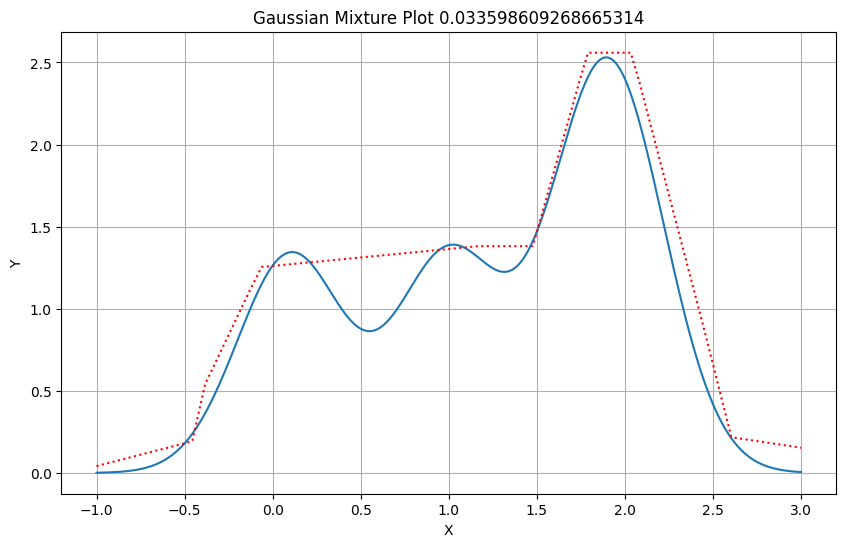

Epoch [1000/1000], Loss: 0.0336
12


In [60]:
import torch.profiler
from IPython.display import clear_output

model = SmallNN().to(device)
L = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.3)

epochs = 1000

#X = torch.randn(4000, 1).to(device)
X = torch.rand(4000, 1).to(device) * 5 - 1
Y = gaussian_mixture(X).to(device)

def training_step():
    y_pred = model(X)
    loss = L(y_pred, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def time_pytorch_function(func):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func()

    start.record()
    func()
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)

time_pytorch_function(training_step)

#with torch.autograd.profiler.profile(use_device='cuda') as prof:
for e in range(epochs):
    y_pred = model(X)
    loss = L(y_pred, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if e % 5 == 0:
        with torch.no_grad():
            test_X = torch.linspace(-1, 3, 1000)
            test_Y = gaussian_mixture(test_X)
            model_Y = model(test_X.reshape(-1, 1).to(device)).cpu()
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
            plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
            plt.title(f'Gaussian Mixture Plot {loss.item()}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()
        
    if (e + 1) % 100 == 0:
        print(f"Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}")
        print(torch.cuda.utilization())
            #free, total = torch.cuda.mem_get_info(device)
            #mem_used_MB = (total - free) / 1024 ** 2
            #print(mem_used_MB)
            #print(torch.cuda.memory_summary())
    #nvidia-smi -lms 100 --query-gpu=index,gpu_name,memory.total,memory.used,memory.free,temperature.gpu,pstate,utilization.gpu,utilization.memory --format=csv

#print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#prof.export_chrome_trace("trace_with_grad_GPU.json")

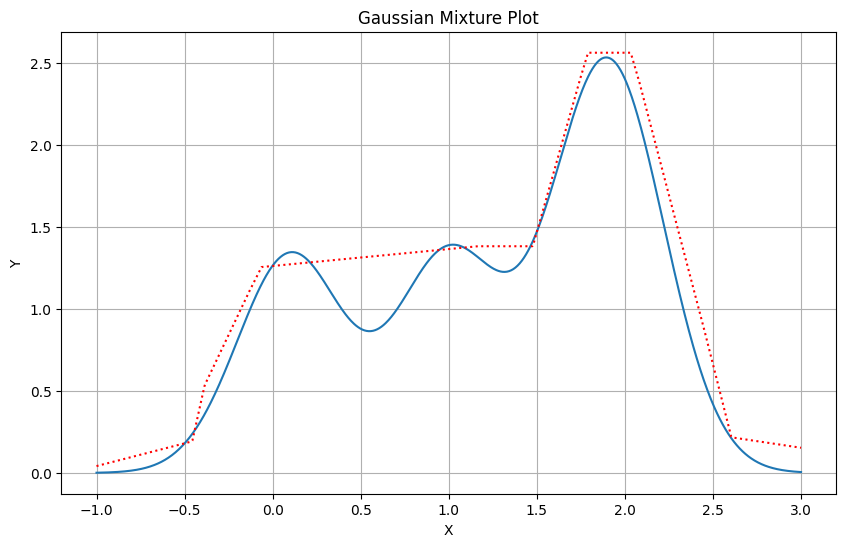

In [61]:
test_X = torch.linspace(-1, 3, 1000)
test_Y = gaussian_mixture(test_X)
model_Y = model(test_X.reshape(-1, 1).to(device))
model_Y = model_Y.cpu()
plt.figure(figsize=(10, 6))
plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
plt.title('Gaussian Mixture Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()